<a href="https://colab.research.google.com/github/lilaceri/Working-with-data-/blob/main/fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [59]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
# !pip install -q sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc


try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2021-04-22 09:37:24--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘insurance.csv’

insurance.csv           [ <=>                ]  49.09K  --.-KB/s    in 0.007s  

2021-04-22 09:37:24 (6.46 MB/s) - ‘insurance.csv’ saved [50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [76]:
#print(len(dataset.index))
#1338
# train_dataset = dataset.sample(n = 1070)
# test_dataset = dataset.sample(n=268)

train_dataset, test_dataset = train_test_split(dataset, test_size=0.20)
# print(train_dataset.shape, test_dataset.shape)


train_labels = train_dataset.pop("expenses")
test_labels = test_dataset.pop("expenses")

print(train_labels.shape, test_labels.shape)
# train_dataset.head(10)
# train_labels.head(10)
print(train_dataset.shape)
print(test_dataset.shape)
for col in train_dataset.columns:
    print(col)

print(train_dataset['age'])


(1070,) (268,)
(1070, 6)
(268, 6)
age
sex
bmi
children
smoker
region
379     62
522     51
1014    38
435     60
293     22
        ..
700     21
969     39
206     59
1019    21
1032    30
Name: age, Length: 1070, dtype: int64


ValueError: ignored

In [48]:
# train_dataset.age.hist(bins=20)
# train_dataset.sex.value_counts().plot(kind='barh')
# pd.concat([train_dataset, train_labels], axis=1).groupby('sex').expenses.mean().plot(kind='barh').set_xlabel('expenses')
train_labels.max()

63770.43

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_22 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

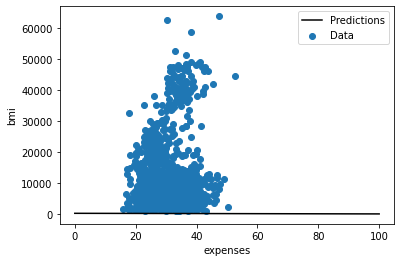

In [108]:
bmi = np.array(train_dataset['bmi'])
bmi_normalizer = preprocessing.Normalization(input_shape=[1,])
bmi_normalizer.adapt(bmi)

bmi_model = tf.keras.Sequential([bmi_normalizer,layers.Dense(units=1)])
bmi_model.summary()
bmi_model.predict(bmi[:10])

bmi_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


history = bmi_model.fit(
    train_dataset['bmi'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [bmi]')
  plt.legend()
  plt.grid(True)

# plot_loss(history)

x = tf.linspace(0.0, 100, 101)
y = bmi_model.predict(x)

def plot_bmi(x, y):
  plt.scatter(train_dataset['bmi'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('expenses')
  plt.ylabel('bmi')
  plt.legend()

plot_bmi(x,y)

train_dataset['sex'] = train_dataset['sex'].astype('category')
train_dataset['smoker'] = train_dataset['smoker'].astype('category')
train_dataset['region'] = train_dataset['region'].astype('category')

train_dataset['sex'] = train_dataset['sex'].cat.codes
train_dataset['smoker'] = train_dataset['smoker'].cat.codes
train_dataset['region'] = train_dataset['region'].cat.codes
train_dataset.head()

test_dataset['sex'] = test_dataset['sex'].astype('category')
test_dataset['smoker'] = test_dataset['smoker'].astype('category')
test_dataset['region'] = test_dataset['region'].astype('category')

test_dataset['sex'] = test_dataset['sex'].cat.codes
test_dataset['smoker'] = test_dataset['smoker'].cat.codes
test_dataset['region'] = test_dataset['region'].cat.codes


In [116]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_bmi_model = build_and_compile_model(bmi_normalizer)
dnn_bmi_model.summary()

history = dnn_bmi_model.fit(
    train_dataset['bmi'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

# plot_loss(history)

x = tf.linspace(0.0, 100, 101)
y = dnn_bmi_model.predict(x)

# plot_bmi(x, y)

model = build_and_compile_model(normalizer)
model.summary()

history = model.fit(
    train_dataset, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)
test_results = {}
test_results['dnn_bmi_model'] = dnn_bmi_model.evaluate(
    test_dataset['bmi'], test_labels,
    verbose=0)
test_results['model'] = model.evaluate(test_dataset, test_labels, verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error']).T


Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_22 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_89 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_90 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
____________________________

,Mean absolute error
dnn_bmi_model,9368.662109
model,7951.228516


In [121]:
# y = W*x + B - linear equation 

CATERGORICAL_COLUMNS = ['sex', 'smoker', 'region', 'children',]
NUMERIC_COLUMNS = ['age', 'bmi']

feature_columns = []
for feature_name in CATERGORICAL_COLUMNS:
  vocabulary = train_dataset[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.int32))

print(feature_columns)

def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

# train_input_fn = make_input_fn(train_dataset, train_labels, batch_size=10)()
# for feature_batch, label_batch in train_input_fn.take(1):
#   print('Some feature keys:', list(feature_batch.keys()))
#   print()
#   print('A batch of class:', feature_batch['region'].numpy())
#   print()
#   print('A batch of Labels:', label_batch.numpy())

train_input_fn = make_input_fn(train_dataset, train_labels)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
# print(train_input_fn.take(1))

eval_input_fn = make_input_fn(test_dataset, test_labels, num_epochs=1, shuffle=False)

model = tf.estimator.LinearRegressor(feature_columns=feature_columns)

model.train(train_input_fn)  # train
result = model.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result)  # the result variable is simply a dict of stats about our model

# train_dtypes = train_dataset.select_dtypes(include=['object']).copy()
# test_dtypes = test_dataset.select_dtypes(include=['object']).copy()

# train_dataset['sex'] = train_dataset['sex'].astype('category')
# train_dataset['smoker'] = train_dataset['smoker'].astype('category')
# train_dataset['region'] = train_dataset['region'].astype('category')

# train_dataset['sex'] = train_dataset['sex'].cat.codes
# train_dataset['smoker'] = train_dataset['smoker'].cat.codes
# train_dataset['region'] = train_dataset['region'].cat.codes
#train_dataset.head()

#northwest: 0
#northeast: 1
#southwest: 2
#southeast: 3
#no: 0
#yes: 1
#male: 0
#female:1





{'average_loss': 375438800.0, 'label/mean': 14927.682, 'loss': 362577340.0, 'prediction/mean': 509.92154, 'global_step': 340}


In [117]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels , verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)


9/9 - 0s - loss: 7951.2285


TypeError: ignored